<a href="https://colab.research.google.com/github/MachineLearnia/Python-Machine-Learning/blob/master/29%20-%20Modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:

url = 'https://raw.githubusercontent.com/MachineLearnia/Python-Machine-Learning/master/Dataset/dataset.csv'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")
data.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# PRE-PROCESSING

In [4]:
df = data.copy()
df.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Création des sous-ensembles (suite au EDA)

In [0]:
missing_rate = df.isna().sum()/df.shape[0]

In [0]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [0]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [8]:
df = df[key_columns + blood_columns + viral_columns]
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
44477f75e8169d2,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126e9dd13932f68,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
a46b4402a0e5696,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f7d619a94f97c45,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d9e41465789c2b5,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected


## TrainTest - Nettoyage - Encodage

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [11]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [12]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [0]:
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
        
    return df

In [0]:
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [0]:
def imputation(df):
    #df['is na'] = (df['Parainfluenza 3'].isna()) | (df['Leukocytes'].isna())
    #df = df.fillna(-999)
    df = df.dropna(axis=0)
    return  df

In [0]:
def preprocessing(df):
    
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y

In [17]:
X_train, y_train = preprocessing(trainset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
X_test, y_test = preprocessing(testset)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Procédure d'évaluation

In [0]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [0]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

## Modellisation

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [0]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [0]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [0]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

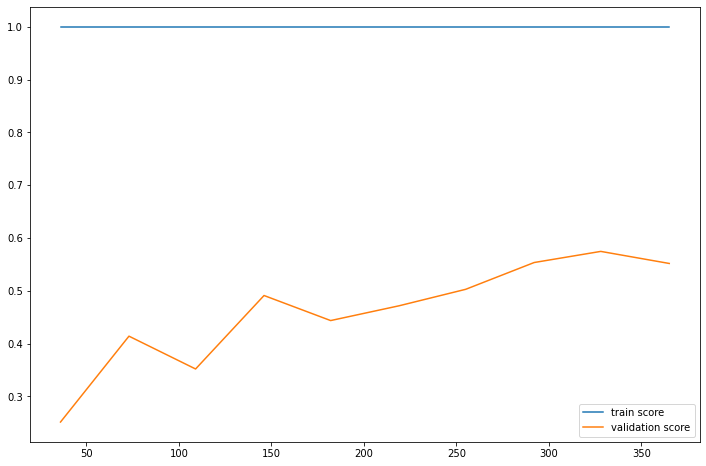

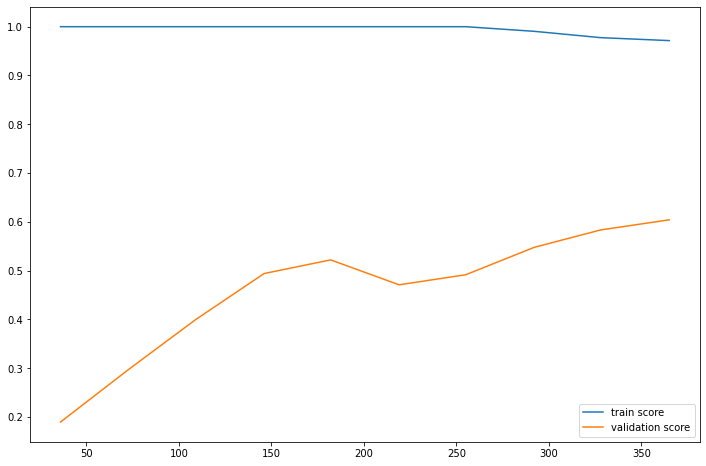

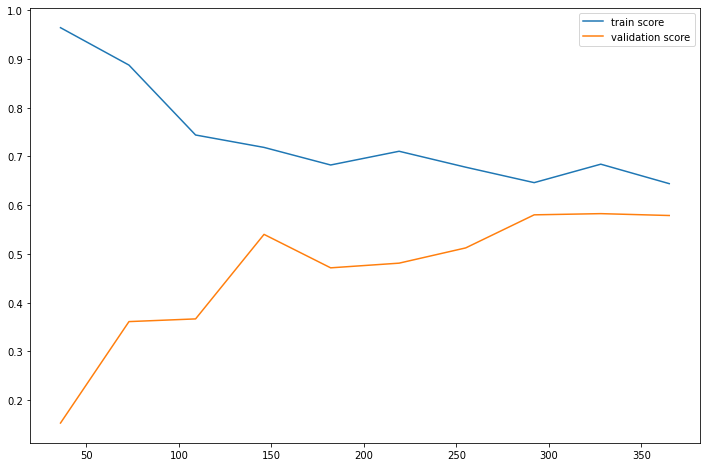

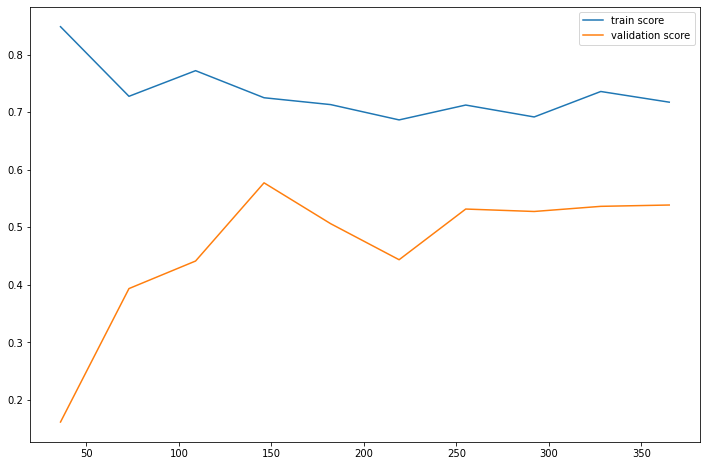

In [30]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## OPTIMISATION

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [32]:
SVM

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('polynomialfeatures',
                                  PolynomialFeatures(degree=2,
                                                     include_bias=False,
                                                     interaction_only=False,
                                                     order='C')),
                                 ('selectkbest',
                                  SelectKBest(k=10,
                                              score_func=<function f_classif at 0x7f453d76d158>))],
                          verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel

In [0]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

In [34]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0005, 'svc__C': 1000, 'pipeline__selectkbest__k': 53, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111



[[90  5]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        95
           1       0.62      0.50      0.55        16

    accuracy                           0.88       111
   macro avg       0.77      0.72      0.74       111
weighted avg       0.87      0.88      0.88       111



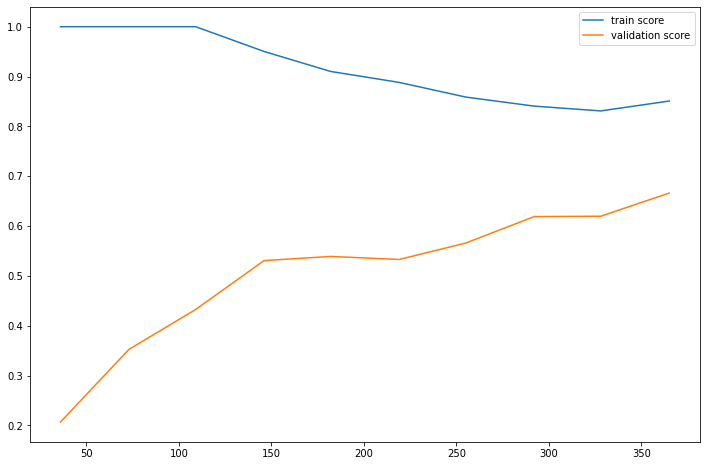

In [35]:
evaluation(grid.best_estimator_)

## Precision Recall Curve

In [0]:
from sklearn.metrics import precision_recall_curve

In [0]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

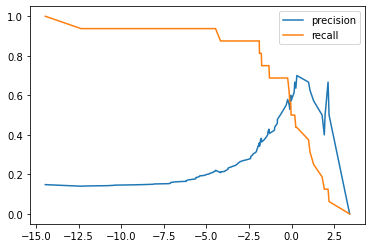

In [38]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [0]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [0]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [0]:
from sklearn.metrics import recall_score

In [42]:
f1_score(y_test, y_pred)

0.5365853658536586

In [43]:
recall_score(y_test, y_pred)

0.6875